In [22]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.special import lambertw
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/0.1GeV.root
threshold: 0.02282
Top 10 hit energies (MeV) with event IDs:
  Event 1723: Energy = 6.119075 MeV at (x=12.50, y=2.50, z=63.38)
  Event 1183: Energy = 3.828318 MeV at (x=2.50, y=2.50, z=43.17)
  Event 2121: Energy = 3.099841 MeV at (x=12.50, y=7.50, z=63.38)
  Event 3716: Energy = 3.020672 MeV at (x=2.50, y=12.50, z=83.57)
  Event 1983: Energy = 2.993242 MeV at (x=2.50, y=2.50, z=63.38)
  Event 2553: Energy = 2.827063 MeV at (x=-2.50, y=7.50, z=22.98)
  Event 838: Energy = 2.756406 MeV at (x=17.50, y=17.50, z=43.17)
  Event 4415: Energy = 2.748896 MeV at (x=82.50, y=42.50, z=63.38)
  Event 3265: Energy = 2.564315 MeV at (x=27.50, y=-12.50, z=123.97)
  Event 1999: Energy = 2.552668 MeV at (x=2.50, y=2.50, z=22.98)
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in

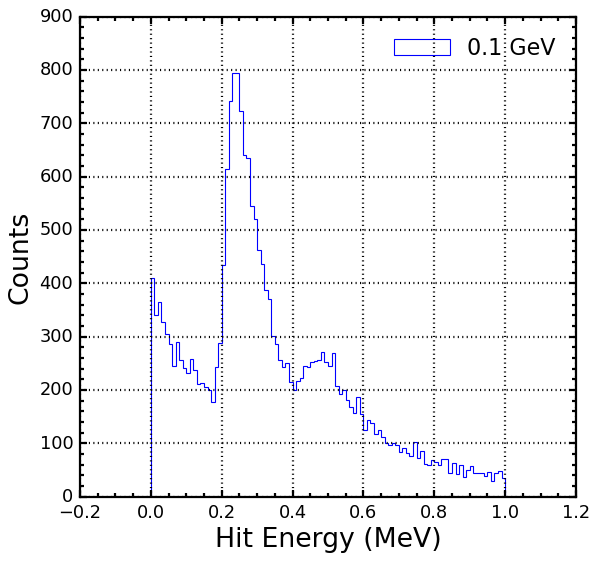

In [23]:
def ConstructHists(E_reco,Nbins=50):
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges
# 打开 ROOT 文件，载入 events tree
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  # mm
SamplingLayer=30
ECAL_layers=120
CellSize=5.0  # mm
Threshold=Threshold_i*MIP_table[Si]
DataPath=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
ParticleEnergy=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
E_sum_list = []
N_hits_list = []
E_true_list = []
for i_E in range(len(ParticleEnergy)):
    input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    if i_E == 0:
        print("threshold:", Threshold)
        energy_flat = ak.to_numpy(ak.flatten(energy))
        pos_x_flat = ak.to_numpy(ak.flatten(pos_x))
        pos_y_flat = ak.to_numpy(ak.flatten(pos_y))
        pos_z_flat = ak.to_numpy(ak.flatten(pos_z))
        hits_per_event = ak.to_numpy(ak.num(energy, axis=1))
        event_ids = np.repeat(np.arange(len(hits_per_event)), hits_per_event)

        plt.hist(energy_flat*1000,
             bins=100 , histtype='step',range=(0., 1), density=False,
             label=f'{ParticleEnergy[i_E]} GeV')
        plt.xlabel('Hit Energy (MeV)')
        plt.ylabel('Counts')
        #plt.yscale('log')
        #plt.ylim(1e3, 1e4)
        plt.legend()
        top10_idx = np.argsort(energy_flat)[-10:][::-1]  # indices of 10 largest energies
        print("Top 10 hit energies (MeV) with event IDs:")
        for idx in top10_idx:
            print(f"  Event {event_ids[idx]}: Energy = {energy_flat[idx]*1000:.6f} MeV at "
              f"(x={pos_x_flat[idx]:.2f}, y={pos_y_flat[idx]:.2f}, z={pos_z_flat[idx]:.2f})")

    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    Event_energy = ak.sum(energy, axis=1) * 1000
    Number_hits  = ak.num(energy, axis=1)
    E_sum_list.append(Event_energy)
    N_hits_list.append(Number_hits)
    E_true_list.append([ParticleEnergy[i_E]]*len(Event_energy))



E_sum = ak.to_numpy(ak.concatenate(E_sum_list))
N_hits = ak.to_numpy(ak.concatenate(N_hits_list))
E_true = ak.to_numpy(ak.concatenate(E_true_list))
hist_E = []
for i_E in range(len(ParticleEnergy)):
    #Sum of E
    mask = E_true == ParticleEnergy[i_E]
    counts, bin_edges = ConstructHists((E_sum[mask]),Nbins=50)
    hist = {
        'counts': counts,
        'bin_edges': bin_edges,
        'Energy': ParticleEnergy[i_E]
        }
    hist_E.append(hist)

In [24]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(E, type, bin_edges, counts):    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')
    if type == "E":
        plt.title(f"Deposited Energy {E} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = max(bin_edges[0], mean - k*theta) # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-100, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]


    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / mean_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * mean_gamma - np.sqrt(k) * theta * (theta)) / (mean_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (mean_gamma**2)
    dr_dtheta = (np.sqrt(k) * mean_gamma - np.sqrt(k) * theta * (k - 1.0)) / (mean_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")

    #Gaussian Fit
    params_gauss_initial = np.array([max(counts), res_gamma, peak_gamma])
    lower_bounds = 0.5 * params_gauss_initial
    upper_bounds = 100 * params_gauss_initial
    print(f"Initial Gaussian Fit Parameters: {params_gauss_initial}")
    params_gauss, cov_gauss = curve_fit(fit_gaussian, bin_centers, counts, p0=params_gauss_initial, bounds=(lower_bounds, upper_bounds))
    peak_gauss = peak_gamma
    sigma_gauss = res_gamma * peak_gamma
    fit_mask = (bin_centers >= peak_gauss - 2 * sigma_gauss) & (bin_centers <= peak_gauss + 2 * sigma_gauss)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]
    params_gauss, cov_gauss = curve_fit(fit_gaussian, x_fit, y_fit, p0=params_gauss_initial)
    x_fit_gauss = x_fit
    y_fit_gauss = fit_gaussian(x_fit, *params_gauss)
    peak_gauss = params_gauss[2]
    peak_gauss_error = np.sqrt(cov_gauss[2, 2])
    mean_gauss = peak_gauss
    mean_gauss_error = peak_gauss_error
    res_gauss = params_gauss[1]
    res_gauss_error = np.sqrt(cov_gauss[1, 1])
    print(f"Gaussian Fit Peak: {peak_gauss} ± {peak_gauss_error}, Resolution: {res_gauss} ± {res_gauss_error}")

    #Log Normal Fit
    var = rms**2
    sigma = np.sqrt(np.log(var/(mean**2)+1))
    scale = np.sqrt( var / ( np.exp(sigma**2) * (np.exp(sigma**2) - 1)) )
    loc = max(peak - scale*np.exp(-sigma**2), 0.1)
    params_log_normal_initial = np.array([max(counts), sigma, loc, scale])
    lower_bounds = 0.001 * params_log_normal_initial
    upper_bounds = 1000 * params_log_normal_initial
    print(f"Initial Log Normal Fit Parameters: {params_log_normal_initial}")
    params_log_normal, cov_log_normal = curve_fit(fit_log_normal, bin_centers, counts, p0=params_log_normal_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Log Normal Fit Parameters: {params_log_normal}")
    x_fit_log_normal = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_log_normal = fit_log_normal(x_fit_log_normal, *params_log_normal)
    sigma, loc, scale = params_log_normal[1], params_log_normal[2], params_log_normal[3]
    peak_log_normal=loc + scale * np.exp(-sigma**2)
    mean_log_normal = loc + scale * np.exp(sigma**2 / 2)
    var = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2)
    res_log_normal = np.sqrt(var) / mean_log_normal    
    # ---- error propagation ----
    # partial derivatives for peak
    d_peak_d_sigma = -2 * sigma * scale * np.exp(-sigma**2)
    d_peak_d_loc = 1.0
    d_peak_d_scale = np.exp(-sigma**2)    
    # partial derivatives for variance
    d_var_d_sigma = (2*sigma*np.exp(sigma**2) * np.exp(2*np.log(scale) + sigma**2)
                     + (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * 2*sigma)
    d_var_d_scale = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * (2/scale)
    # derivatives for resolution
    d_res_d_sigma = (0.5 / np.sqrt(var) * d_var_d_sigma * peak - np.sqrt(var) * d_peak_d_sigma) / (peak**2)
    d_res_d_loc = -np.sqrt(var) * d_peak_d_loc / (peak**2)
    d_res_d_scale = (0.5 / np.sqrt(var) * d_var_d_scale * peak - np.sqrt(var) * d_peak_d_scale) / (peak**2)
    # errors
    peak_grad = np.array([0, d_peak_d_sigma, d_peak_d_loc, d_peak_d_scale])
    mean_grad = np.array([0, d_peak_d_sigma/2, d_peak_d_loc, d_peak_d_scale])  
    res_grad  = np.array([0, d_res_d_sigma, d_res_d_loc, d_res_d_scale])    
    peak_log_normal_error = np.sqrt(peak_grad @ cov_log_normal @ peak_grad)
    mean_log_normal_error = np.sqrt(mean_grad @ cov_log_normal @ mean_grad)
    res_log_normal_error  = np.sqrt(res_grad @ cov_log_normal @ res_grad)
    print(f"Log Normal Fit Peak: {peak_log_normal} ± {peak_log_normal_error}, Resolution: {res_log_normal} ± {res_log_normal_error}")

    plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")
    plt.plot(x_fit_gamma, y_fit_gamma, 'g-', label="Gamma Fit")
    plt.plot(x_fit_log_normal, y_fit_log_normal, 'm-', label="Log Normal Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
            mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
            mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error)



<>:130: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2909178/1137045438.py:130: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")


In [25]:
# #This cell is left here for debug
# hist = hist_E[9]
# (mean_gauss,mean_gauss_error,peak_gauss,peak_gauss_error,res_gauss,res_gauss_error,
#  mean_gamma,mean_gamma_error,peak_gamma,peak_gamma_error,res_gamma,res_gamma_error,
#  mean_log_normal,mean_log_normal_error,peak_log_normal,peak_log_normal_error,res_log_normal,res_log_normal_error) = fit_all(hist['Energy'],"E", hist['bin_edges'], hist['counts'])




Mean: 1.8514564273118805, Peak: 0.9289476871490479, RMS: 1.0646648424651861
Initial Gamma Fit Parameters: [np.float64(713.7176366150379), np.float64(1.7390040071436115), np.float32(0.0), np.float64(1.0646648424651861)]
Gamma Fit Parameters: [7.04640104e+02 2.84879951e+00 1.03616285e-01 6.09055824e-01]
Gamma Fit Peak: 1.8386942174814154 ± 0.024381573757656108, Resolution: 0.5590858915702069 ± 0.01738075131337668
Initial Gaussian Fit Parameters: [328.           0.55908589   1.22963839]
Gaussian Fit Peak: 1.4379933011896215 ± 0.04314448664218461, Resolution: 0.5283830417715184 ± 0.036980844842539676
Initial Log Normal Fit Parameters: [3.28000000e+02 5.34494982e-01 1.00000000e-01 1.60501025e+00]
Log Normal Fit Parameters: [7.28900277e+02 6.17932725e-01 1.00000000e-04 1.69074424e+00]
Log Normal Fit Peak: 1.15420823941268 ± 0.022319080650811444, Resolution: 0.681860307986896 ± 0.11891040296956913


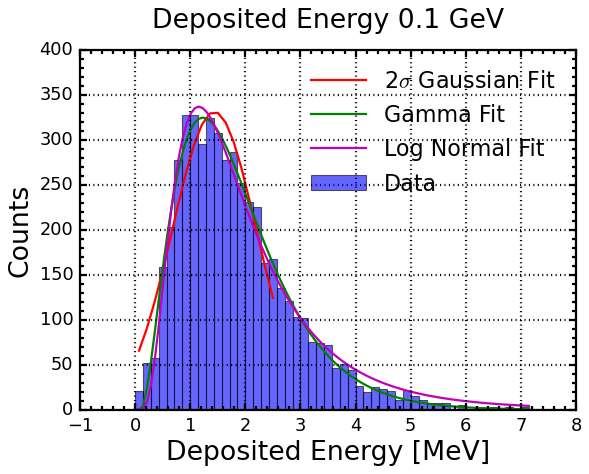

Mean: 4.633674306268034, Peak: 3.8523945808410645, RMS: 1.6992307395624229
Initial Gamma Fit Parameters: [np.float64(1242.2108100950718), np.float64(2.726924718570754), np.float32(0.0), np.float64(1.6992307395624229)]
Gamma Fit Parameters: [1.23155127e+03 6.54223312e+00 4.25379109e-01 6.40223509e-01]
Gamma Fit Peak: 4.613870548349307 ± 0.03261601018083626, Resolution: 0.35491897553900037 ± 0.007388885277447452
Initial Gaussian Fit Parameters: [328.           0.35491898   3.97364704]
Gaussian Fit Peak: 4.222166283755351 ± 0.04797862080551607, Resolution: 0.33919031589130694 ± 0.012967085635572237
Initial Log Normal Fit Parameters: [3.28000000e+02 3.55208819e-01 1.00000000e-01 4.35038126e+00]
Log Normal Fit Parameters: [1.24681370e+03 3.68156745e-01 1.00000000e-04 4.44485454e+00]
Log Normal Fit Peak: 3.8815459647747916 ± 0.033988021463518224, Resolution: 0.38098319939225395 ± 0.016999322605568263


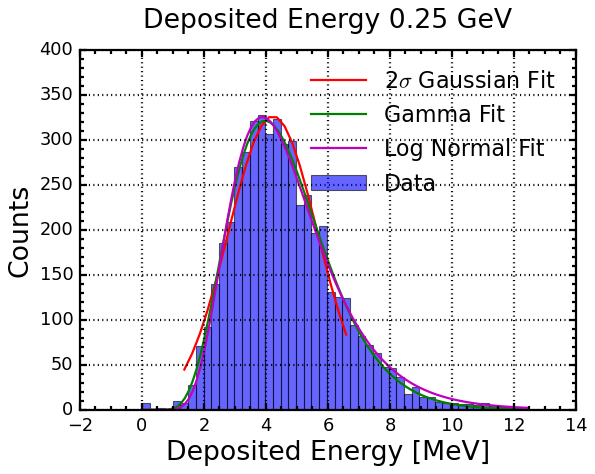

Mean: 9.28678405585885, Peak: 8.107061386108398, RMS: 2.4183607002309317
Initial Gamma Fit Parameters: [np.float64(2078.733593225479), np.float64(3.8401153537485313), np.float32(0.0), np.float64(2.4183607002309317)]
Gamma Fit Parameters: [2.06982612e+03 1.10678460e+01 1.41484271e+00 7.10381329e-01]
Gamma Fit Peak: 9.27723382829097 ± 0.04258808794828093, Resolution: 0.2547443663838153 ± 0.004142497109421412
Initial Gaussian Fit Parameters: [3.79000000e+02 2.54744366e-01 8.56685250e+00]
Gaussian Fit Peak: 8.871212539139355 ± 0.061609334087140886, Resolution: 0.24737952397709165 ± 0.007685640417647126
Initial Log Normal Fit Parameters: [3.79000000e+02 2.56149200e-01 1.00000000e-01 8.98706314e+00]
Log Normal Fit Parameters: [2.08297970e+03 2.59174354e-01 1.00000000e-04 9.07352104e+00]
Log Normal Fit Peak: 8.484159506872867 ± 0.04374194042803876, Resolution: 0.2635853410818958 ± 0.007072993040627357


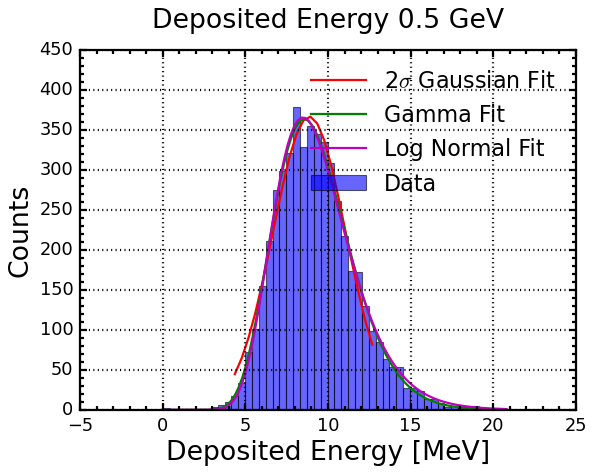

Mean: 18.577068991851807, Peak: 18.954185485839844, RMS: 3.4345379810400125
Initial Gamma Fit Parameters: [np.float64(2609.4436645507812), np.float64(3.309144335156707), np.float32(7.211687), np.float64(3.4345379810400125)]
Gamma Fit Parameters: [ 2.60620509e+03  3.19951229e+01 -6.84645120e-01  6.00891254e-01]
Gamma Fit Peak: 18.540944388442362 ± 0.08634078965555592, Resolution: 0.18331834295925656 ± 0.003524588653250505
Initial Gaussian Fit Parameters: [3.18000000e+02 1.83318343e-01 1.79400531e+01]
Gaussian Fit Peak: 18.19661310819896 ± 0.08163962068517848, Resolution: 0.1807595283103797 ± 0.004938833463526433
Initial Log Normal Fit Parameters: [3.18000000e+02 1.83329262e-01 1.29045270e+00 1.82674934e+01]
Log Normal Fit Parameters: [2.61641416e+03 1.85760681e-01 1.29045270e-03 1.83967412e+01]
Log Normal Fit Peak: 17.774042659138473 ± 0.0902982088653406, Resolution: 0.18736185623363918 ± 0.004720798303846264


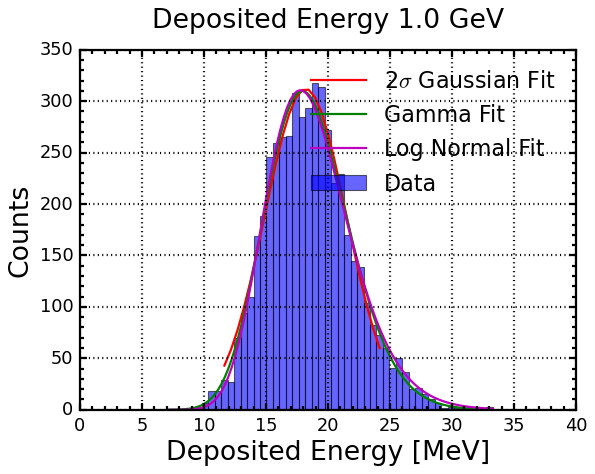

Mean: 37.350531751858185, Peak: 35.42970657348633, RMS: 4.863292467423947
Initial Gamma Fit Parameters: [np.float64(3463.0523681640625), np.float64(2.887744575108295), np.float32(23.306585), np.float64(4.863292467423947)]
Gamma Fit Parameters: [3.46802050e+03 2.88774458e+01 1.11654931e+01 9.10653426e-01]
Gamma Fit Peak: 37.462837995109616 ± 0.1309980972394755, Resolution: 0.13062666522557353 ± 0.0025897704334017276
Initial Gaussian Fit Parameters: [3.15000000e+02 1.30626665e-01 3.65521846e+01]
Gaussian Fit Peak: 36.97392940577342 ± 0.11621882062320346, Resolution: 0.12961487583329612 ± 0.003411949095813279
Initial Log Normal Fit Parameters: [3.15000000e+02 1.29659916e-01 1.00000000e-01 3.70378848e+01]
Log Normal Fit Parameters: [3.47011193e+03 1.30677500e-01 1.00000591e-04 3.71655397e+01]
Log Normal Fit Peak: 36.53636652760413 ± 0.12952586085424916, Resolution: 0.13123702149202976 ± 0.0030175759360427075


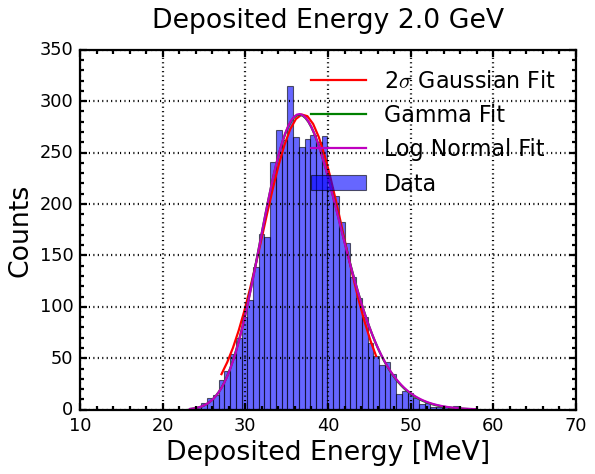

Mean: 93.18609668761462, Peak: 93.09629821777344, RMS: 7.744718152634668
Initial Gamma Fit Parameters: [np.float64(5931.974109649658), np.float64(3.920219708991964), np.float32(62.8251), np.float64(7.744718152634668)]
Gamma Fit Parameters: [5.90023488e+03 3.92021971e+01 4.55470292e+01 1.22383629e+00]
Gamma Fit Peak: 93.5241006262439 ± 0.21380365842503163, Resolution: 0.08193227049986321 ± 0.0016086986305640773
Initial Gaussian Fit Parameters: [3.50000000e+02 8.19322705e-02 9.23002643e+01]
Gaussian Fit Peak: 92.87885881988434 ± 0.19035394348016418, Resolution: 0.08103671755145837 ± 0.002205994867914572
Initial Log Normal Fit Parameters: [3.50000000e+02 8.29672498e-02 8.67429935e-01 9.28659217e+01]
Log Normal Fit Parameters: [5.89814008e+03 8.15914555e-02 8.67429935e-04 9.30623598e+01]
Log Normal Fit Peak: 92.44575332197509 ± 0.20496491013922047, Resolution: 0.08172667678132782 ± 0.0015637321785023678


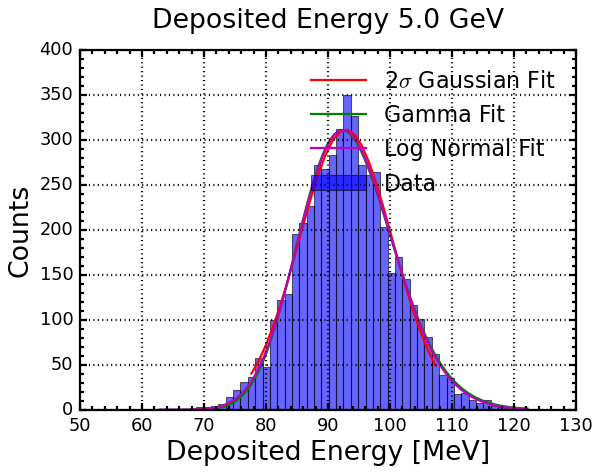

Mean: 186.58570997063376, Peak: 185.66212463378906, RMS: 11.000234619543257
Initial Gamma Fit Parameters: [np.float64(10458.308898925781), np.float64(4.934648289563465), np.float32(132.30342), np.float64(11.000234619543257)]
Gamma Fit Parameters: [1.04104954e+04 4.93464829e+01 1.11068917e+02 1.53811583e+00]
Gamma Fit Peak: 186.96952392307847 ± 0.1796275532280989, Resolution: 0.057789152144984646 ± 0.0006585080605997692
Initial Gaussian Fit Parameters: [4.06000000e+02 5.77891521e-02 1.85431408e+02]
Gaussian Fit Peak: 186.15007396426878 ± 0.1610188676786847, Resolution: 0.057022248170863356 ± 0.0009262369046587446
Initial Log Normal Fit Parameters: [4.06000000e+02 5.89042649e-02 1.00000000e-01 1.86262291e+02]
Log Normal Fit Parameters: [1.04030600e+04 5.74753245e-02 1.00000004e-04 1.86350715e+02]
Log Normal Fit Peak: 185.7362376002614 ± 0.1594384144397662, Resolution: 0.05752279251426552 ± 0.0005769545101269189


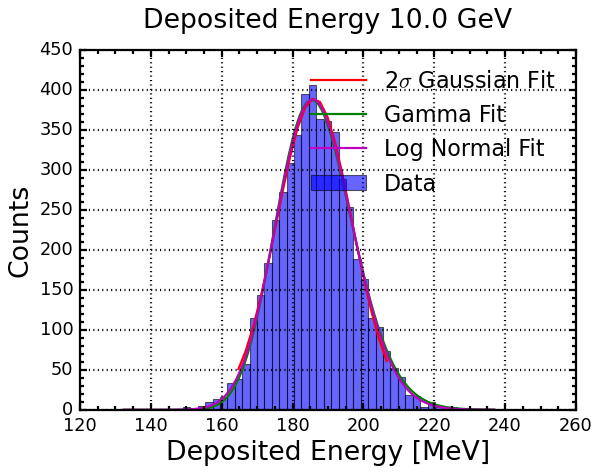

Mean: 372.2957521338975, Peak: 376.3656005859375, RMS: 15.689802898504878
Initial Gamma Fit Parameters: [np.float64(12402.22216796875), np.float64(3.9325986028795796), np.float32(310.59406), np.float64(15.689802898504878)]
Gamma Fit Parameters: [1.23423544e+04 3.93259860e+01 2.75803232e+02 2.47700489e+00]
Gamma Fit Peak: 373.2138919368389 ± 0.4382313790222905, Resolution: 0.04162065140874514 ± 0.0008114624971422532
Initial Gaussian Fit Parameters: [3.34000000e+02 4.16206514e-02 3.70736887e+02]
Gaussian Fit Peak: 371.90908457370136 ± 0.3641077366494041, Resolution: 0.04115690353917931 ± 0.001057306637392861
Initial Log Normal Fit Parameters: [3.34000000e+02 4.21246898e-02 5.05948314e+00 3.71965581e+02]
Log Normal Fit Parameters: [1.23304115e+04 4.12271384e-02 5.05948327e-03 3.72109694e+02]
Log Normal Fit Peak: 371.4828246182644 ± 0.3921848593886184, Resolution: 0.041244102485763275 ± 0.0006802254089677385


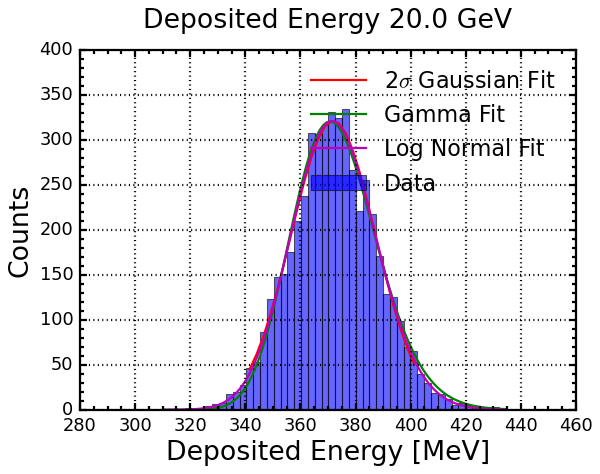

Mean: 558.1174263417137, Peak: 561.693603515625, RMS: 19.329951852035517
Initial Gamma Fit Parameters: [np.float64(15924.701385498047), np.float64(4.182192411644774), np.float32(477.27585), np.float64(19.329951852035517)]
Gamma Fit Parameters: [1.58948100e+04 4.18219241e+01 4.34787024e+02 2.97668034e+00]
Gamma Fit Peak: 559.2775233301588 ± 0.5924498122412634, Resolution: 0.0344196807999313 ± 0.0007268528214735742
Initial Gaussian Fit Parameters: [3.51000000e+02 3.44196808e-02 5.56300843e+02]
Gaussian Fit Peak: 557.7270512194887 ± 0.4694527096455252, Resolution: 0.033619562812362044 ± 0.000906566818396474
Initial Log Normal Fit Parameters: [3.51000000e+02 3.46238229e-02 4.57888974e+00 5.57782988e+02]
Log Normal Fit Parameters: [1.58651033e+04 3.40148775e-02 4.57892545e-03 5.57952355e+02]
Log Normal Fit Peak: 557.3117496578114 ± 0.524509231668574, Resolution: 0.034024439721969744 ± 0.0006037780581104849


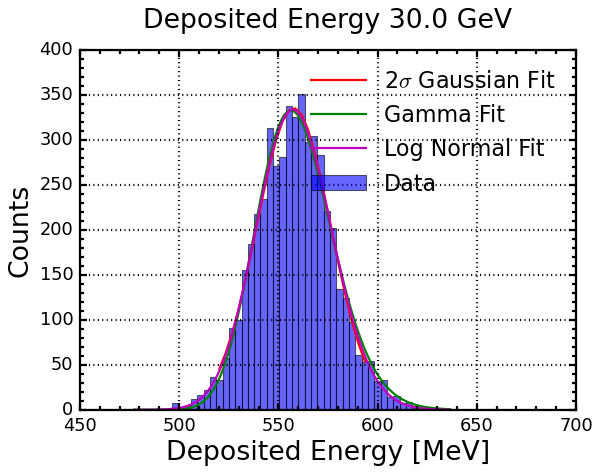

Mean: 744.6263965073288, Peak: 748.8333129882812, RMS: 22.163896392477128
Initial Gamma Fit Parameters: [np.float64(17740.591796875), np.float64(4.373537140305927), np.float32(647.6918), np.float64(22.163896392477128)]
Gamma Fit Parameters: [1.78348128e+04 4.37353714e+01 5.96092503e+02 3.42857788e+00]
Gamma Fit Peak: 746.0426304490381 ± 0.5683916370381971, Resolution: 0.030392525114541064 ± 0.0005201972206898235
Initial Gaussian Fit Parameters: [3.25000000e+02 3.03925251e-02 7.42614053e+02]
Gaussian Fit Peak: 744.3694905224776 ± 0.4475683359659939, Resolution: 0.03018797248392166 ± 0.0006576901998685149
Initial Log Normal Fit Parameters: [3.25000000e+02 2.97585336e-02 5.19538837e+00 7.44296760e+02]
Log Normal Fit Parameters: [1.78164170e+04 3.00946862e-02 5.19538837e-03 7.44521919e+02]
Log Normal Fit Peak: 743.8531133487701 ± 0.48830038812183485, Resolution: 0.030101291605052424 ± 0.00041958189557076087


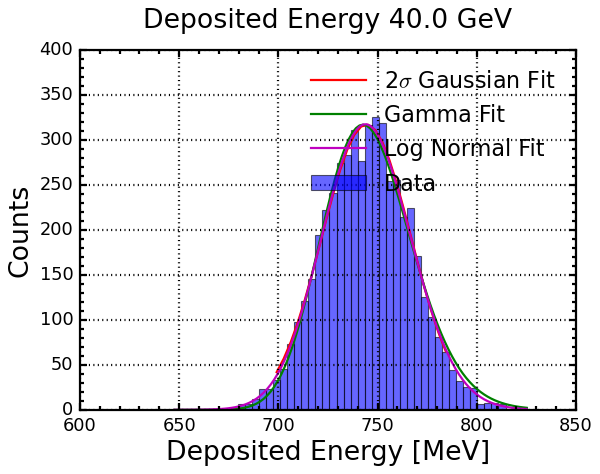

Mean: 930.6267839194728, Peak: 932.8578491210938, RMS: 24.56933551990917
Initial Gamma Fit Parameters: [np.float64(20046.55859375), np.float64(4.399445173289882), np.float32(822.53534), np.float64(24.56933551990917)]
Gamma Fit Parameters: [2.00838189e+04 4.39944517e+01 7.66904802e+02 3.76459426e+00]
Gamma Fit Peak: 932.5260625729632 ± 0.6915767279629522, Resolution: 0.026776644454556207 ± 0.000505570915011057
Initial Gaussian Fit Parameters: [3.53000000e+02 2.67766445e-02 9.28761468e+02]
Gaussian Fit Peak: 930.6721338995837 ± 0.5319500967170181, Resolution: 0.026711736403548555 ± 0.0006186106600826269
Initial Log Normal Fit Parameters: [3.53000000e+02 2.63962486e-02 3.20319509e+00 9.30302628e+02]
Log Normal Fit Parameters: [2.00719444e+04 2.65279128e-02 4.70169983e-02 9.30756802e+02]
Log Normal Fit Peak: 930.1490479012435 ± 0.5860223073505018, Resolution: 0.026531240830688273 ± 0.00040300157644294286


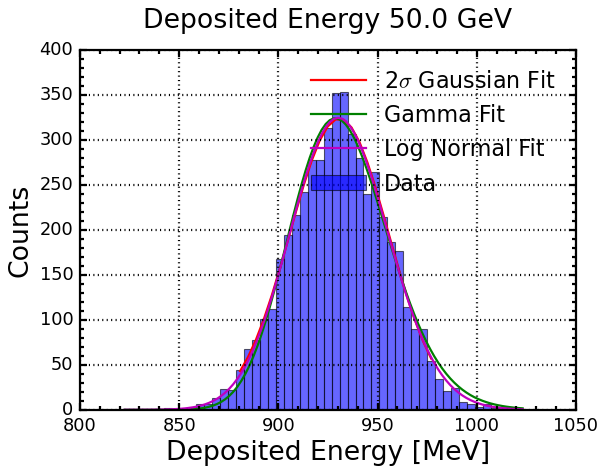

Mean: 1117.108440292273, Peak: 1115.732666015625, RMS: 27.475963415553363
Initial Gamma Fit Parameters: [np.float64(22801.263427734375), np.float64(4.119671244064482), np.float32(1003.9165), np.float64(27.475963415553363)]
Gamma Fit Parameters: [2.27370747e+04 4.11967124e+01 9.43761566e+02 4.26276781e+00]
Gamma Fit Peak: 1119.3735862875608 ± 0.6541909837935856, Resolution: 0.024442628295425817 ± 0.000399881043339151
Initial Gaussian Fit Parameters: [3.61000000e+02 2.44426283e-02 1.11511082e+03]
Gaussian Fit Peak: 1117.208091395946 ± 0.42705371339950093, Resolution: 0.024182212277489856 ± 0.0004134422950516752
Initial Log Normal Fit Parameters: [3.61000000e+02 2.45918914e-02 1.00000000e-01 1.11677070e+03]
Log Normal Fit Parameters: [2.27126344e+04 2.41581524e-02 1.00044028e-04 1.11739939e+03]
Log Normal Fit Peak: 1116.7475525301943 ± 0.4876352239315027, Resolution: 0.024161675393197107 ± 0.0002791786606494967


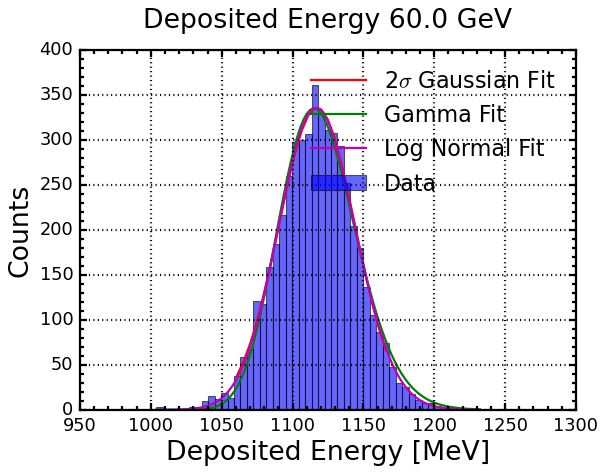

In [26]:
#Fit Sum of E and Save as CSV
results = []
for i_E in range(len(ParticleEnergy)):
    hist = hist_E[i_E]
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(hist['Energy'],"E", hist['bin_edges'], hist['counts'])
    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, f"Reco_Results/SumE_Fit_Threshold{Threshold_i}.csv")
#outputfile_name = os.path.join(DataPath, f"Reco_Results/SumE_Fit.csv")
df.to_csv(outputfile_name, index=False)



In [27]:
# def plot_binned(x, y, num_bins=30, color="blue", label=None):
#     """Plot mean y in bins of x."""
#     bin_means, bin_edges, _ = binned_statistic(x, y, statistic='mean', bins=num_bins)
#     bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#     plt.plot(bin_centers, bin_means, marker="o", linestyle="None", color=color, label=label)
# def exp_func(x, a, b, c):
#     return a * np.exp(b * x) + c
# def Combined_fit(x, y, fit_range=(0,65), plot=True, num_bins=100):
#     #Step 1: Linear
#     linear_range = (10,60)
#     mask_lin = (x > linear_range[0]) & (x < linear_range[1])
#     coeffs_lin = np.polyfit(x[mask_lin], y[mask_lin], 1)
#     y_lin = np.poly1d(coeffs_lin)(x)
#     residual = y - y_lin
#     print("Step 1 Linear fit coeffs:", coeffs_lin)
    
#     if plot:
#         plt.figure(figsize=(5,4))
#         plot_binned(x, y, num_bins=num_bins, color="blue", label="Data (bin mean)")
#         plt.plot(x[mask_lin], y_lin[mask_lin], color="red", linestyle="--", label="Step1: Linear")
#         plt.xlabel("x")
#         plt.ylabel("y")
#         plt.title("Step 1: Linear Fit")
#         plt.grid(True, linestyle="--", alpha=0.5)
#         plt.show()
    
#     # Step 2: exp fit
#     #residual = y
#     fit_range = (0, 3)
#     mask_fit = (x > fit_range[0]) & (x < fit_range[1])
#     def fit_func2(x, a, b, c):
#         return a * np.exp(b * x) + c
#     coeff_exp1, _ = curve_fit(fit_func2, x[mask_fit], residual[mask_fit], p0=(1, -0.1, 0))
#     x_fit2 = np.linspace(fit_range[0], fit_range[1], 200)
#     y_fit2 = fit_func2(x_fit2, *coeff_exp1)
#     if plot:
#         plt.figure(figsize=(5,4))
#         plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual (bin mean)")
#         plt.plot(x_fit2, y_fit2, color="red", linestyle="-", label="Step2: exp Fit")
#         plt.xlabel("x")
#         plt.ylabel("Residual")
#         plt.title("Step 2: exp Fit Residual")
#         plt.grid(True, linestyle="--", alpha=0.5)
#         plt.show()

#     residual = y - fit_func2(x, *coeff_exp1)

#     # Step 4: Linear again
#     mask_fit = (x > fit_range[0]) & (x < fit_range[1])
#     params_lin2 = np.polyfit(x[mask_fit], residual[mask_fit], 1)
#     y_lin2 = np.poly1d(params_lin2)(x)
#     print("Step 3 Linear fit coeffs:", params_lin2)
    
#     if plot:
#         plt.figure(figsize=(5,4))
#         plot_binned(x, residual, num_bins=num_bins, color="blue", label="Residual after Step2 (bin mean)")
#         plt.plot(x, y_lin2, color="red", linestyle="--", label="Step3: Linear Fit")
#         plt.xlabel("x")
#         plt.ylabel("Residual")
#         plt.title("Step 3: Linear Fit Residual")
#         plt.grid(True, linestyle="--", alpha=0.5)
#         plt.show()
    
#     # Final combined function
#     def f(x_val):
#         return ( 
#                 fit_func2(x_val, *coeff_exp1) + 
#                 #fit_func3(x_val, *coeff_fit3) + 
#                 np.poly1d(params_lin2)(x_val))
#     def f_inv(y_val):
#         a, b, c = coeff_exp1
#         m, d = params_lin2
#         term = (a * b / m) * np.exp(b * (y_val - (c + d)) / m)
#         return (y_val - (c + d)) / m - (1.0 / b) * lambertw(term).real
#     return f, f_inv

# E_calib_fit, E_calib_fit_inv = Combined_fit(E_true, N_hits, fit_range=(0,65), plot=True, num_bins=200)
# x_fit = np.linspace(0, 65, 200)
# y_fit = E_calib_fit(x_fit)
# plt.figure(figsize=fig_size)
# plot_binned(E_true, N_hits, color="blue", label="Number of hits", num_bins=100)
# plt.plot(x_fit, y_fit, color="red", linestyle="-", label="Combined Fit")
# plt.xlabel("E_truth [GeV]")
# plt.ylabel("Number of hits")
# plt.title("Number of hits vs True Energy")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.legend(loc="upper left")  
# plt.show()

# N_hits_calib = E_calib_fit_inv(N_hits)

# hist_N = []
# for i_E in range(len(ParticleEnergy)):
#     #Number of hits
#     mask = E_true == ParticleEnergy[i_E]
#     N_bins = min(50, (N_hits[mask].max()-N_hits[mask].min()))
#     print(f"N_bins for {ParticleEnergy[i_E]} GeV: {N_bins}")
#     counts, bin_edges = ConstructHists(N_hits[mask], Nbins=N_bins)
#     hist = {
#         'counts': counts,
#         'bin_edges': bin_edges,
#         'Energy': ParticleEnergy[i_E]
#         }
#     hist_N.append(hist)
hist_N = []
for i_E in range(len(ParticleEnergy)):
    mask = E_true == ParticleEnergy[i_E]
    n_min = int(N_hits[mask].min())
    n_max = int(N_hits[mask].max()) + 1   # +1 to include the last value
    if n_max - n_min < 1000:
        bin_edges = np.arange(n_min, n_max + 1, 1)  # bin width = 1
        counts, _ = np.histogram(N_hits[mask], bins=bin_edges)
    else:
        counts, bin_edges = ConstructHists(N_hits[mask], Nbins=50)
    hist = {
        'counts': counts,
        'bin_edges': bin_edges,
        'Energy': ParticleEnergy[i_E]
    }
    hist_N.append(hist)


Mean: 5.049, Peak: 4.5, RMS: 2.0142489915598816
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(2.5066414436131534), np.int64(0), np.float64(2.0142489915598816)]
Gamma Fit Parameters: [ 5.00053038e+03  8.28665529e+00 -7.60497400e-01  7.02001566e-01]
Gamma Fit Peak: 5.056747590755953 ± 0.01805460756890672, Resolution: 0.3996284895045726 ± 0.0036944589165147715
Initial Gaussian Fit Parameters: [1.03400000e+03 3.99628490e-01 4.35474602e+00]
Gaussian Fit Peak: 4.656285840931479 ± 0.10762765489922577, Resolution: 0.40089688748252544 ± 0.027165280986836574
Initial Log Normal Fit Parameters: [1.03400000e+03 3.84304306e-01 4.54296295e-01 4.68959068e+00]
Log Normal Fit Parameters: [5.06602029e+03 4.22674932e-01 4.54296295e-04 4.92651858e+00]
Log Normal Fit Peak: 4.120970587137671 ± 0.09637311584207252, Resolution: 0.4422376302884295 ± 0.04921121752659774


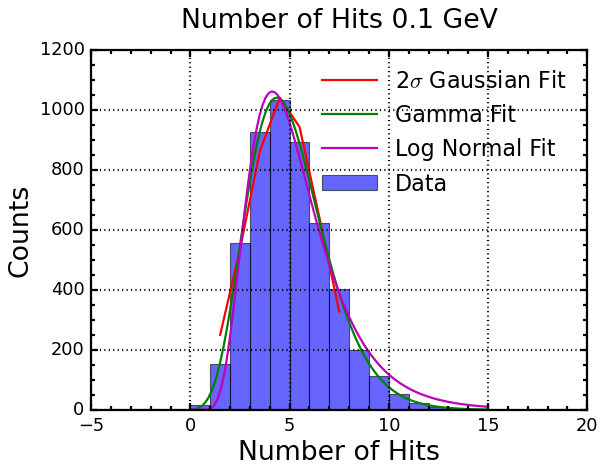

Mean: 11.3466, Peak: 11.5, RMS: 3.09959165697677
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(3.660675745613235), np.int64(0), np.float64(3.09959165697677)]
Gamma Fit Parameters: [ 4.99640101e+03  2.34213581e+01 -3.57185511e+00  6.38462256e-01]
Gamma Fit Peak: 11.381798005803958 ± 0.05320882025753282, Resolution: 0.2714753433818978 ± 0.0038650032942193708
Initial Gaussian Fit Parameters: [6.52000000e+02 2.71475343e-01 1.07433358e+01]
Gaussian Fit Peak: 11.03095418449888 ± 0.08622921004851129, Resolution: 0.27308799711450743 ± 0.008753161837818994
Initial Log Normal Fit Parameters: [6.52000000e+02 2.68273490e-01 1.31453054e+00 1.09455481e+01]
Log Normal Fit Parameters: [5.02180460e+03 2.78629095e-01 1.31453054e-03 1.12787295e+01]
Log Normal Fit Peak: 10.437555247662782 ± 0.09671826656446317, Resolution: 0.2840935216109029 ± 0.011575018408793032


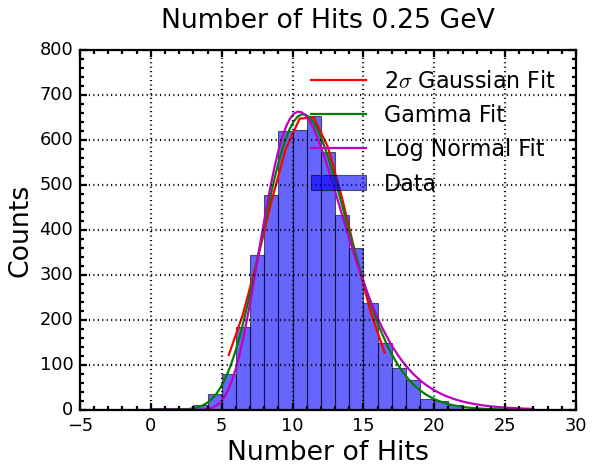

Mean: 21.1524, Peak: 20.5, RMS: 4.338476027362605
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(4.875536908949735), np.int64(0), np.float64(4.338476027362605)]
Gamma Fit Parameters: [ 4.97142897e+03  3.02464667e+01 -2.12000038e+00  7.70226071e-01]
Gamma Fit Peak: 21.176616784492456 ± 0.06738949736580227, Resolution: 0.20003176226288968 ± 0.002446420889669018
Initial Gaussian Fit Parameters: [4.72000000e+02 2.00031762e-01 2.04063907e+01]
Gaussian Fit Peak: 20.73645685570589 ± 0.08851811437571461, Resolution: 0.19822160340350592 ± 0.004633619993513386
Initial Log Normal Fit Parameters: [4.72000000e+02 2.02996309e-01 6.15468413e-01 2.07210403e+01]
Log Normal Fit Parameters: [4.98773280e+03 2.02701692e-01 6.15468413e-04 2.10107203e+01]
Log Normal Fit Peak: 20.165542739906734 ± 0.08234766567381974, Resolution: 0.20479589949409333 ± 0.004251948883333867


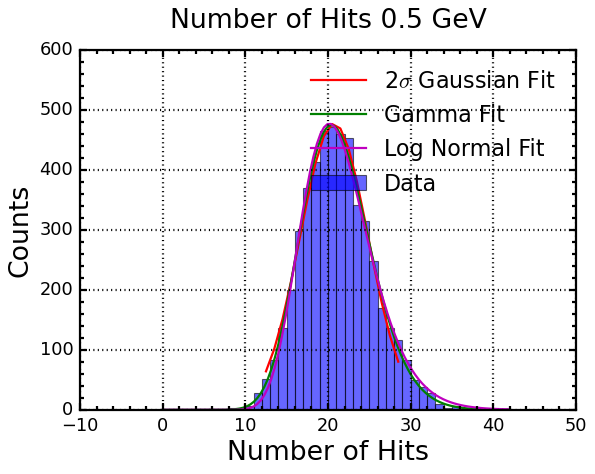

Mean: 39.157, Peak: 36.5, RMS: 6.208007007083674
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(5.179923277036754), np.int64(7), np.float64(6.208007007083674)]
Gamma Fit Parameters: [ 4.97452863e+03  5.17992328e+01 -4.55134340e+00  8.44912788e-01]
Gamma Fit Peak: 39.21449077860735 ± 0.11503700590018409, Resolution: 0.1550697073106556 ± 0.002103207570872161
Initial Gaussian Fit Parameters: [3.52000000e+02 1.55069707e-01 3.83695780e+01]
Gaussian Fit Peak: 38.74927331216165 ± 0.13147780487780067, Resolution: 0.1548126815498625 ± 0.003707822829747305
Initial Log Normal Fit Parameters: [3.52000000e+02 1.57558525e-01 1.00000000e-01 3.86739738e+01]
Log Normal Fit Parameters: [4.97917986e+03 1.56026286e-01 1.00000020e-04 3.90346626e+01]
Log Normal Fit Peak: 38.09596837842583 ± 0.12538265069790386, Resolution: 0.15698030605267205 ± 0.003098399354662023


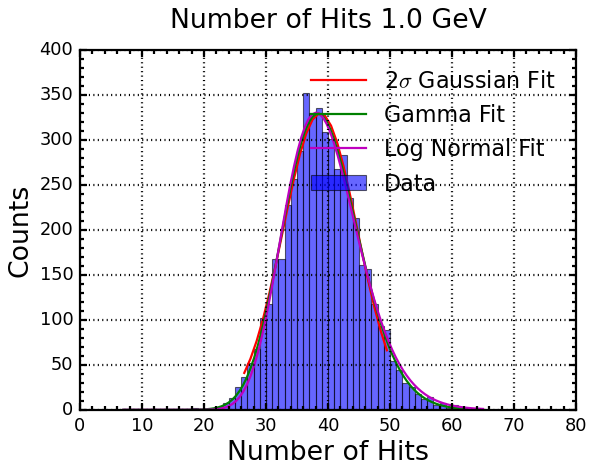

Mean: 71.9608, Peak: 70.5, RMS: 8.405454381531078
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(6.419736227296125), np.int64(18), np.float64(8.405454381531078)]
Gamma Fit Parameters: [4.98559802e+03 6.41973622e+01 5.94177419e+00 1.02992351e+00]
Gamma Fit Peak: 72.06014661586104 ± 0.13883286874883582, Resolution: 0.11451659359399005 ± 0.0013348028512181241
Initial Gaussian Fit Parameters: [2.53000000e+02 1.14516594e-01 7.10302231e+01]
Gaussian Fit Peak: 71.49388919565497 ± 0.16483978670235286, Resolution: 0.11381267944118678 ± 0.0025334070352744102
Initial Log Normal Fit Parameters: [2.53000000e+02 1.16410519e-01 1.00000000e-01 7.14748630e+01]
Log Normal Fit Parameters: [4.98992182e+03 1.14894774e-01 1.00000393e-04 7.17817099e+01]
Log Normal Fit Peak: 70.84046017739009 ± 0.14096649061578811, Resolution: 0.1152748351883048 ± 0.0015649565223805257


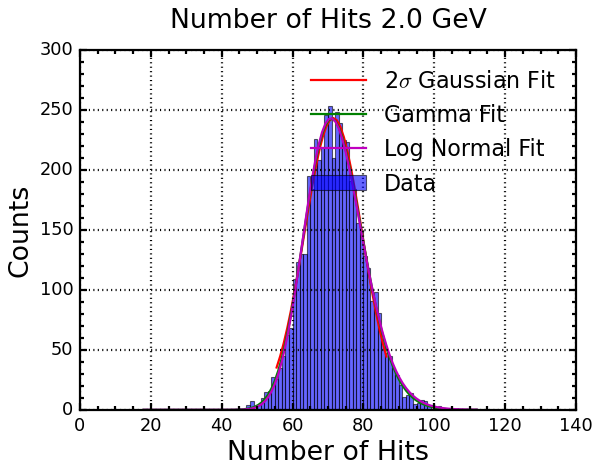

Mean: 157.8602, Peak: 162.5, RMS: 13.235197616960617
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(9.43395056224883), np.int64(33), np.float64(13.235197616960617)]
Gamma Fit Parameters: [4.97414094e+03 9.43395056e+01 3.31301956e+01 1.32527704e+00]
Gamma Fit Peak: 158.15617655488523 ± 0.22885593306301827, Resolution: 0.08138930041701764 ± 0.000970327583066504
Initial Gaussian Fit Parameters: [1.68000000e+02 8.13893004e-02 1.56830900e+02]
Gaussian Fit Peak: 157.44767475530907 ± 0.2681168298422912, Resolution: 0.08104235867788315 ± 0.001853510371831191
Initial Log Normal Fit Parameters: [1.6800000e+02 8.3694478e-02 6.2897771e+00 1.5730828e+02]
Log Normal Fit Parameters: [4.97392223e+03 8.14175761e-02 6.28977735e-03 1.57750687e+02]
Log Normal Fit Peak: 156.71473404721678 ± 0.22947014933017174, Resolution: 0.08154944748433379 ± 0.00100130992682814


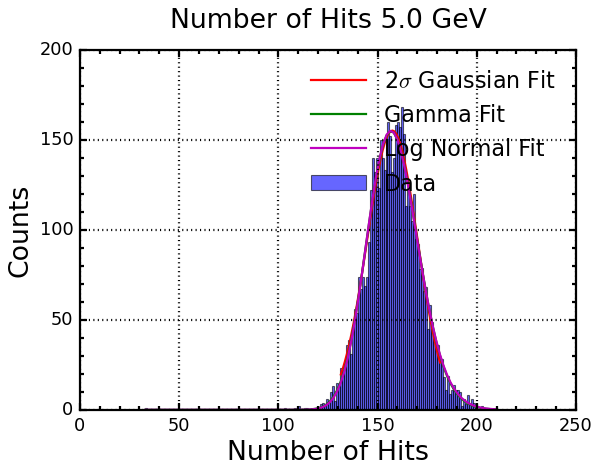

Mean: 280.187, Peak: 274.5, RMS: 19.1534182588905
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(10.295133606685122), np.int64(83), np.float64(19.1534182588905)]
Gamma Fit Parameters: [5.02703034e+03 1.00337400e+02 8.84307282e+01 1.91534183e+00]
Gamma Fit Peak: 280.611147101111 ± 0.29744157399316706, Resolution: 0.06837113587825905 ± 0.0007054149534240881
Initial Gaussian Fit Parameters: [1.24000000e+02 6.83711359e-02 2.78695805e+02]
Gaussian Fit Peak: 279.61505263609115 ± 0.35791065968477964, Resolution: 0.06874879936044498 ± 0.0014000156702785682
Initial Log Normal Fit Parameters: [1.24000000e+02 6.82797514e-02 1.00000000e-01 2.79534627e+02]
Log Normal Fit Parameters: [5.02570311e+03 6.83148405e-02 1.00000173e-04 2.79978704e+02]
Log Normal Fit Peak: 278.67521066267915 ± 0.29608974443089575, Resolution: 0.06839459863774337 ± 0.000742090306468674


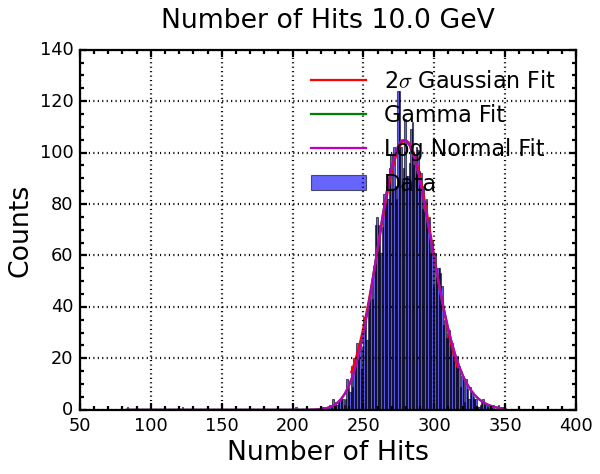

Mean: 485.578, Peak: 478.5, RMS: 25.98116848796451
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(8.028045393594265), np.int64(277), np.float64(25.98116848796451)]
Gamma Fit Parameters: [5.01201818e+03 8.02804539e+01 2.53352246e+02 2.90302384e+00]
Gamma Fit Peak: 486.408317096906 ± 0.48506121152592147, Resolution: 0.05347545882185754 ± 0.0006655786663477399
Initial Gaussian Fit Parameters: [9.00000000e+01 5.34754588e-02 4.83505293e+02]
Gaussian Fit Peak: 484.91994759054677 ± 0.5218818631255393, Resolution: 0.053293003417095294 ± 0.0011718399363758972
Initial Log Normal Fit Parameters: [9.00000000e+01 5.34674186e-02 1.00000000e-01 4.84884419e+02]
Log Normal Fit Parameters: [5.00925539e+03 5.33085272e-02 1.00001458e-04 4.85307148e+02]
Log Normal Fit Peak: 483.93006003475244 ± 0.4781738157159616, Resolution: 0.05334641169703635 ± 0.0006661499487579282


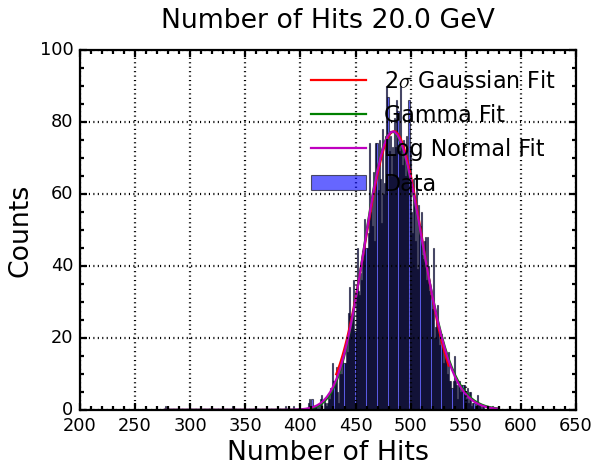

Mean: 664.686, Peak: 663.5, RMS: 31.70290529273303
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(2.8920377849728616), np.int64(573), np.float64(31.70290529273303)]
Gamma Fit Parameters: [4969.53126358   28.92037784  497.05307327    5.8275476 ]
Gamma Fit Peak: 665.5879516170191 ± 0.6496628131063116, Resolution: 0.04708497658231197 ± 0.0006929614793298025
Initial Gaussian Fit Parameters: [7.90000000e+01 4.70849766e-02 6.59760404e+02]
Gaussian Fit Peak: 662.3767387988951 ± 0.6122636564250992, Resolution: 0.046264720458755314 ± 0.0009996194460067146
Initial Log Normal Fit Parameters: [7.90000000e+01 4.76689702e-02 1.07572290e+00 6.63931236e+02]
Log Normal Fit Parameters: [4.97389964e+03 1.12873597e-01 3.88177275e+02 2.75360985e+02]
Log Normal Fit Peak: 660.0522910412597 ± 0.6389969479482217, Resolution: 0.047166089770015 ± 0.000721687291925955


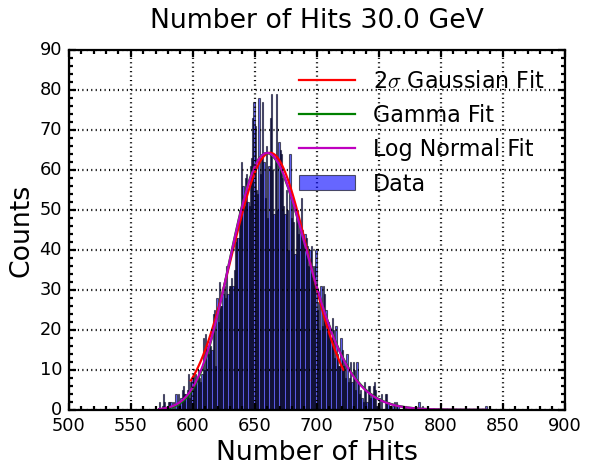

Mean: 825.7926, Peak: 813.5, RMS: 35.50237436059735
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(3.486882278425648), np.int64(702), np.float64(35.50237436059735)]
Gamma Fit Parameters: [5008.15631934   34.86882278  615.29465095    6.07432409]
Gamma Fit Peak: 827.0991810151397 ± 0.8051388752068183, Resolution: 0.04336696316475409 ± 0.000679308441359816
Initial Gaussian Fit Parameters: [7.10000000e+01 4.33669632e-02 8.21024857e+02]
Gaussian Fit Peak: 823.9131036446465 ± 0.7027731881567113, Resolution: 0.0429297911904975 ± 0.0009256322600414064
Initial Log Normal Fit Parameters: [7.10000000e+01 4.29720319e-02 1.00000000e-01 8.25030499e+02]
Log Normal Fit Parameters: [5.00406158e+03 4.89017205e-02 9.99384872e+01 7.24564482e+02]
Log Normal Fit Peak: 822.7723313124274 ± 0.7915830092410903, Resolution: 0.04300624827117429 ± 0.0006420934306150472


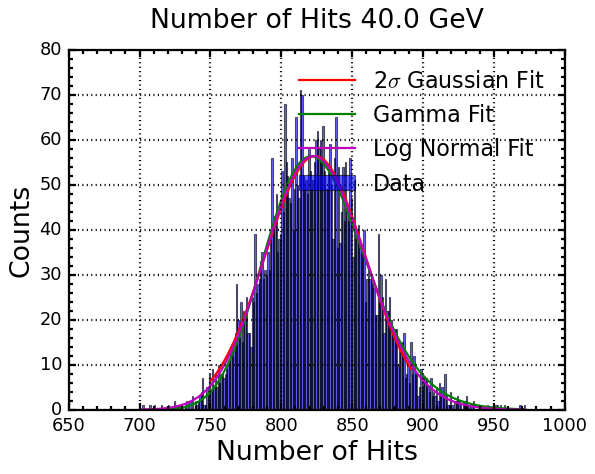

Mean: 976.5638, Peak: 982.5, RMS: 40.69491036431952
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(5.69023983409558), np.int64(745), np.float64(40.69491036431952)]
Gamma Fit Parameters: [4978.22714615   56.90239815  675.18286671    5.30290231]
Gamma Fit Peak: 976.9307251194789 ± 0.7530282206841682, Resolution: 0.04094634513307935 ± 0.0005205216803575555
Initial Gaussian Fit Parameters: [6.40000000e+01 4.09463451e-02 9.71627823e+02]
Gaussian Fit Peak: 973.944980447868 ± 0.7467018150015601, Resolution: 0.04033871102862148 ± 0.0008288700784462513
Initial Log Normal Fit Parameters: [6.40000000e+01 4.16534589e-02 8.47441856e+00 9.75716993e+02]
Log Normal Fit Parameters: [4.98019099e+03 8.20195571e-02 4.89417309e+02 4.85675763e+02]
Log Normal Fit Peak: 971.8367955565025 ± 0.7470408319693677, Resolution: 0.04099030714244308 ± 0.0005303659272523881


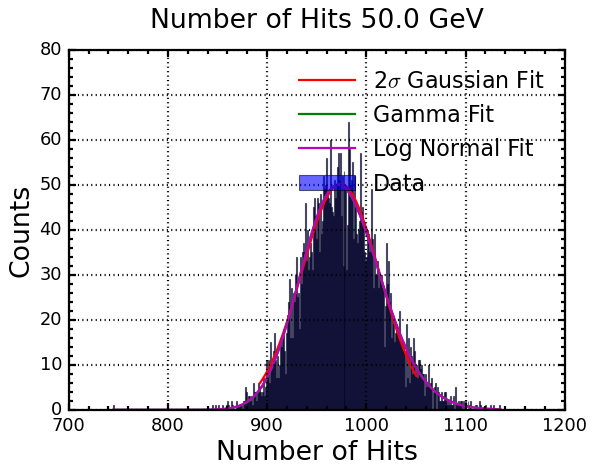

Mean: 1117.5454, Peak: 1099.5, RMS: 43.76698457559076
Initial Gamma Fit Parameters: [np.int64(5000), np.float64(8.009356902223104), np.int64(767), np.float64(43.76698457559076)]
Gamma Fit Parameters: [4957.67384155   48.87921433  822.97796443    6.03054578]
Gamma Fit Peak: 1117.7463043949144 ± 0.6618160448262641, Resolution: 0.037720330100954415 ± 0.00040281938014336737
Initial Gaussian Fit Parameters: [6.00000000e+01 3.77203301e-02 1.11171576e+03]
Gaussian Fit Peak: 1114.4361138052814 ± 0.7655040726038232, Resolution: 0.03722042531129498 ± 0.0007423195150890202
Initial Log Normal Fit Parameters: [6.00000000e+01 3.91484912e-02 1.00000000e-01 1.11668935e+03]
Log Normal Fit Parameters: [4.95610944e+03 4.12294769e-02 1.00000000e+02 1.01512137e+03]
Log Normal Fit Peak: 1113.397263883953 ± 0.6652441991065369, Resolution: 0.03755098490775139 ± 0.0003946831944169093


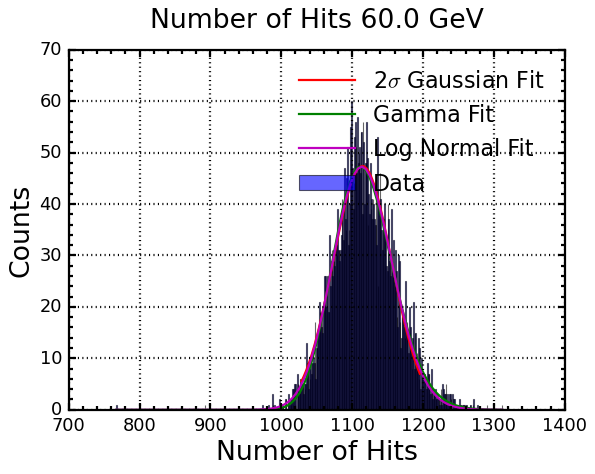

Saving N hits fit results to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer30_in120/Reco_Results/NHits_Fit_Threshold0.1.csv


In [28]:
results = []
for i_E in range(len(ParticleEnergy)):
    hist = hist_N[i_E]
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(hist['Energy'],"N", hist['bin_edges'], hist['counts'])

    results.append({
        "ParticleEnergy": ParticleEnergy[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath, f"Reco_Results/NHits_Fit_Threshold{Threshold_i}.csv")
#outputfile_name = os.path.join(DataPath, f"Reco_Results/NHits_Fit.csv")
print(f"Saving N hits fit results to {outputfile_name}")
df.to_csv(outputfile_name, index=False)

